In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from tqdm import tqdm
import joblib
from typing import Tuple, Optional, Union


# t分布(高次モーメント非存在)

In [8]:
mean_true = 0
alpha = 0.95

def distr_wrapper(
    mean: float, rng: np.random.Generator, size: Union[int, tuple[int]]
) -> np.ndarray:
    return rng.standard_t(df=1, size=size) + mean  # Cauchy distribution


In [9]:
def calc_conf_interval_normal(x: np.ndarray, alpha: float = 0.05) -> float:
    n = len(x)
    x_mean = np.mean(x)
    x_std = np.std(x, ddof=1)
    z_alpha = stats.norm.ppf(1 - alpha)
    ci = z_alpha * x_std / np.sqrt(n)
    return x_mean - ci


In [10]:
def calc_conf_interval_bs(
    rng: np.random.Generator, x: np.ndarray, alpha: float = 0.05, mc: int = 1000
) -> float:
    n = len(x)
    x_mean = np.mean(x)
    bs_samples = distr_wrapper(x_mean, rng, size=(mc, n))
    bs_means = np.mean(bs_samples, axis=1)
    bs_stds = np.std(bs_samples, axis=1, ddof=1)
    studentized_samples = np.sqrt(n) * (bs_means - x_mean) / bs_stds
    upper = np.quantile(studentized_samples, 1 - alpha)
    return x_mean - upper * np.std(x, ddof=1) / np.sqrt(n)  # これ合ってる?


In [13]:
# 信頼区間を計算して、真の平均が信頼区間に入っている確率が0.95 になるか確認する
# normal version

SEED = 42
DEBUG = False
# n_list = [100, 500, 1000]
n_list = [20, 100]

if DEBUG:
    MC = 1000
else:
    MC = 50000

mc_bs = 1000  # bootstrapのサンプル数

prob_seq_list_normal = []
for n in n_list:
    ss = np.random.SeedSequence(SEED)
    child_seeds = ss.spawn(MC)
    streams = [np.random.default_rng(s) for s in child_seeds]

    def main(rng):
        x = distr_wrapper(mean_true, rng, size=n)
        upper = calc_conf_interval_normal(x, alpha)  # change here
        return int(mean_true <= upper)

    res = joblib.Parallel(n_jobs=8, verbose=2)(
        joblib.delayed(main)(rng) for rng in streams
    )
    res = np.array(res)
    prob_seq = np.cumsum(res) / np.array(range(1, MC + 1))
    prob_seq_list_normal.append(prob_seq)

# bootstrap version
prob_seq_list_bs = []
for n in n_list:
    ss = np.random.SeedSequence(SEED)
    child_seeds = ss.spawn(MC)
    streams = [np.random.default_rng(s) for s in child_seeds]

    def main(rng):
        x = distr_wrapper(mean_true, rng, size=n)
        upper = calc_conf_interval_bs(rng, x, alpha, mc=mc_bs)  # change here
        return int(mean_true <= upper)

    res = joblib.Parallel(n_jobs=8, verbose=2)(
        joblib.delayed(main)(rng) for rng in streams
    )
    res = np.array(res)
    prob_seq = np.cumsum(res) / np.array(range(1, MC + 1))
    prob_seq_list_bs.append(prob_seq)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 9200 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 9200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 6384 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 32368 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | el

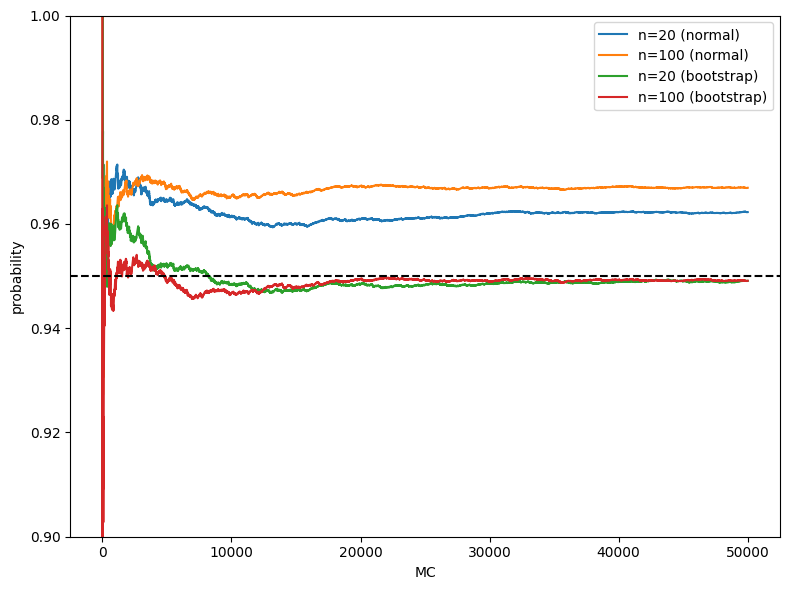

In [16]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for n, prob_seq in zip(n_list, prob_seq_list_normal):
    sns.lineplot(prob_seq, label=f"n={n} (normal)", ax=ax)
for n, prob_seq in zip(n_list, prob_seq_list_bs):
    sns.lineplot(prob_seq, label=f"n={n} (bootstrap)", ax=ax)
ax.legend()
ax.set_xlabel("MC")
ax.set_ylabel("probability")
ax.set_ylim(alpha-0.05, alpha+0.05)
ax.axhline(alpha, color="k", linestyle="--")
fig.tight_layout()


分散の推定値が大きく出るから、正規近似だと信頼区間がかなり広くとられるはずで、上の結果はこの直感と整合的